In [147]:
# from IPython.display import clear_output
# !pip install pandas tqdm torch scikit-learn
# clear_output()

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import models
from utils import save_model, load_model, upload_models_hf, class_weights
from data.dataset import PatientDataset

### Training Configurations

In [16]:
images_path = "dataset/reduced/train"
labels_path = "dataset/reduced/train.csv"
batch_size = 1
model_type = "cnn"
cuda = False
lr = 1e-3
epochs = 5
depth = 64 # number of CT slices

## Data Pre-processing

We begin by filtering out the dataframe for any patients where we are missing CT scans for

In [17]:
entries = os.listdir(images_path)
patient_ids = [int(entry) for entry in entries if os.path.isdir(os.path.join(images_path, entry))]

df = pd.read_csv(labels_path)
df = df[df['patient_id'].isin(patient_ids)]
print(df.shape)

(2886, 6)


Then, we perform a standard train-validation-test split of 80-10-10

In [18]:
# Split the dataset into train, validation, and test sets
train_data, val_test_data = train_test_split(df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(2308, 6)
(289, 6)
(289, 6)


In [19]:
train_data.head()

,patient_id,bowel,extravastion,kidney,liver,spleen
1426,38343,0,1,0,0,1
964,29412,0,0,0,0,0
2608,63193,0,0,0,0,0
662,23709,0,0,0,0,0
2408,58547,0,0,0,0,0


In [ ]:
weights = class_weights(train_data)

Seeding this data into the pytorch dataset object we now have our dataloaders ready for training

In [20]:
train_dataset = PatientDataset(images_path, train_data, n_slices=depth)
val_dataset = PatientDataset(images_path, val_data, n_slices=depth)
test_dataset = PatientDataset(images_path, test_data, n_slices=depth)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# get one sample
inputs, labels = train_dataset[0]

print(inputs.shape)
print(labels.shape)

torch.Size([1, 64, 128, 128])
torch.Size([5])


## Training

In [22]:
if model_type == "cnn":
    model = models.ConvNet3D(
        in_channels=inputs.shape[0],
        out_channels=labels.shape[0],
        depth=inputs.shape[1],
        height=inputs.shape[2],
        width=inputs.shape[3],
    )
elif model_type == "unet":
    model = ...
else:
    raise ValueError("Invalid model selected for training.")

if cuda:
    model = model.cuda()

# test save and loader functions
os.makedirs("checkpoints", exist_ok = True) # create ckpt dir
os.makedirs("plots", exist_ok = True) # create plots dir
save_model(model, "checkpoints/test.pth")
load_model(model, "checkpoints/test.pth")
os.remove("checkpoints/test.pth")

criterion = nn.BCEWithLogitsLoss()  # multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

best_vloss = 1_000_000.

for epoch in range(epochs):
    model.train() # set model to train

    # creating loss tracker
    running_loss = 0.0
    running_vloss = 0.0
    batch_loss = 0.0

    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for i, (inputs, labels) in pbar:
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero gradients for every batch
        optimizer.zero_grad()

        # compute predictions + loss
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)

        loss = (loss * weights).mean()

        # perform backpropagation
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        batch_loss += loss.item()
        if i % 10 == 0:
            batch_loss = batch_loss / 10 # loss per batch
            pbar.set_postfix({'loss': round(batch_loss, 5)})
            batch_loss = 0.0
        break

    avg_loss = running_loss / (i + 1)
    train_losses.append((epoch, avg_loss))

    print("Validation...")
    model.eval() # set model to evaluation
    with torch.no_grad():
        for (inputs, labels) in val_dataloader:
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
                
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            running_vloss += loss.item()
            break

    avg_vloss = running_vloss / len(val_dataloader)
    val_losses.append((epoch, avg_vloss))

    print(f'[EPOCH {epoch}] LOSS train={avg_loss} val={avg_vloss}')

    # save model when
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        save_model(model, f"checkpoints/BEST_model_{timestamp}_{epoch}.pth")

    if epoch != 0 and epoch % 25 == 0:
        save_model(model, f"checkpoints/model_{timestamp}_{epoch}.pth")

Model saved to checkpoints/test.pth
Model loaded from checkpoints/test.pth


  0%|          | 0/2308 [00:07<?, ?it/s, loss=0.064]


Validation...
[EPOCH 0] LOSS train=0.6395382642745971 val=0.00020377794506228094
Model saved to checkpoints/BEST_model_20240413_160742_0.pth


  0%|          | 0/2308 [00:06<?, ?it/s, loss=0.699]


Validation...
[EPOCH 1] LOSS train=6.987225341796875 val=0.0
Model saved to checkpoints/BEST_model_20240413_160742_1.pth


  0%|          | 0/2308 [00:06<?, ?it/s, loss=0.0121]


Validation...
[EPOCH 2] LOSS train=0.12147411108016967 val=0.0


  0%|          | 0/2308 [00:14<?, ?it/s, loss=3.48]


Validation...
[EPOCH 3] LOSS train=34.78602905273438 val=0.0


  0%|          | 0/2308 [00:12<?, ?it/s, loss=0]


Validation...
[EPOCH 4] LOSS train=0.0 val=0.0


We plot the training and validation loss curves

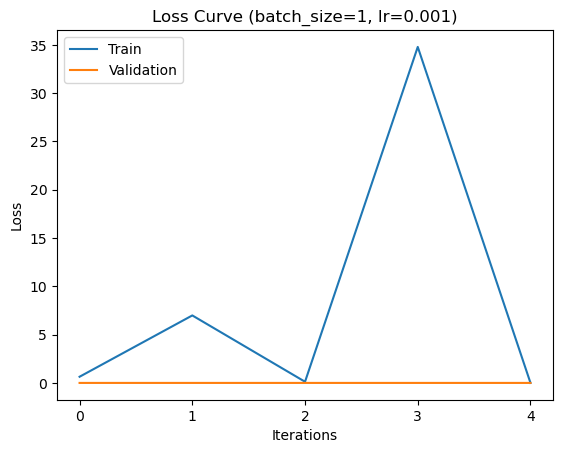

In [33]:
t_iters, t_loss = list(zip(*train_losses))
v_iters, v_loss = list(zip(*val_losses))

plt.title("Loss Curve (batch_size={}, lr={})".format(batch_size, lr))
plt.plot(t_iters, t_loss, label="Train")
plt.plot(t_iters, v_loss, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.xticks(t_iters)
plt.savefig("plots/loss.png")
plt.show()

# Upload Model

In [ ]:
upload_models_hf("checkpoints/", "Pie31415", "abd-trauma-models") # upload to huggingface

# Inference

In [ ]:
load_model(model, "checkpoints/best_model")

In [ ]:
data, labels = train_dataset[0]
data = data.unsqueeze(0).cuda()
outputs = model(data.float())
probs = torch.sigmoid(outputs)
pred = (probs > 0.5).int()

print(f"Reals: {labels}")
print(f"Predictions: {pred}")
